# Handgeschriebene Ziffern

Der beiliegenden Beschreibung der Daten habe ich entnommen, dass es sich um handgeschriebene Ziffern handelt. Die mit 16x16 Bildpunkten abgespeichert sind. Der Beschreibung kann ich weiter entnehmen:

*"The data are in two gzipped files, and each line consists of the digit
id (0-9) followed by the 256 grayscale values."*

Es handelt sich also um eine Textdatei in der in jeder Zeile der Wert der geschriebenen Ziffer sowie die 16x16 = 256 Bildpunkte stehen.

---

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

---

In [2]:
def getNumber(data, digit):
    # wähle alle Zeilen in denen die erste Spalte (Spalte mit den Ziffer) mit 'digit' übereinstimmt
    data_number = pd.DataFrame(data[data[0] == digit]) 
    # schneide die erste Spalte weg und gebe den rest zurück
    separated_data = data_number.iloc[:,1:]
    return separated_data


In [3]:
def getNumberImage(data, digit, aggregation):
    # ruft die Hilfsfunktion getNumber auf um alle Bilddaten Daten zu einer Ziffer zu holen
    image_data = getNumber(data, digit)
    # bilde aus allen Bildern zu der einen Ziffer ein aggrigiertes Bild
    if(aggregation == 'median'):
        df1 = pd.DataFrame(image_data.median())
    else:
        df1 = pd.DataFrame(image_data.mean())        
    
    # wandle das format von (1,256) -> (16,16) und gebe diesen transformierten DataFrame zurück
    return df1.values.reshape(16,16)

In [4]:
class Experiment:
    def __init__(self, targets):
        self.results = pd.DataFrame(targets, columns=["targets"])

        self.input_data = {}
        
        self.names = []        
        self.configs = []

        
    def get_names(self):
        return self.names
    
    
    def get_results(self):
        return self.results
    
    def get_config_map(self):
        for conf in self.configs:
            print "CONFIG:", conf['name'], conf['input_data_name'], "\tNum features:", self.input_data[conf['input_data_name']]['data'].shape[1]
    
    
    def add_input_data(self, name, data, description=""):
        self.input_data[name] = {'description': description, 'data': data}
    
    
    def add_config(self, algo, name, input_data_name):
        # TODO: add check for dublicate names
        if not self.input_data.has_key(input_data_name):
            print "ERROR: feature_set_name not found"
            return 
        
        self.names.append(name)
        self.configs.append({ 'name': name, 'algo': algo, 'input_data_name': input_data_name, 'fit': -1})
        

    def _fit(self, conf):
        # get features
        input_data = self.input_data[conf['input_data_name']]['data']

        # fit the features
        print "Fitting ", conf['name'], "... ",
        
        start = time.time() # startzeit
        conf['fit'] = conf['algo'].fit(input_data)
        end = time.time() # startzeit
        
        print "done in ", end - start , "s." 

        
    def _predict(self, conf, data):
        if data.shape[1] != self.input_data[conf['input_data_name']]['data'].shape[1]:
            print "ERROR: Number of input features does not match (", conf['name'], ")"
            return
        
        print "Predicting data with", conf['name'], "... ",
        
        start = time.time() # startzeit
        self.results[conf['name']] = conf['algo'].predict(data)
        end = time.time() # startzeit
        
        print "done in ", end - start , "s." 

        
    def fit(self):
        '''Only trains algorithms if no fit has been calculated before'''
        for conf in self.configs:
            if conf['fit'] == -1:
                self._fit(conf)

                
    def fit_all(self, data):
        '''Trains all algorithms with given data'''
        for conf in self.configs:
            self._fit(conf)

            
    def refit(self, data):
        '''Retrains all algorithms with given data that have been trained before'''
        for conf in self.configs:
            if conf['fit'] != -1:
                self._fit(conf)

                
    def predict(self, name, data):
        for conf in self.configs:
            if conf['fit'] != -1 and conf['name'] == name:
                self._predict(conf, data)

    def predict_all(self, data):
        for conf in self.configs:
            if conf['fit'] != -1:
                self._predict(conf, data)

                
    def get_count_df(self, name):
        count_matrix = np.zeros((10,10)) 
        for digit in range(0,10):
            cluster_counts = self.results[self.results['targets'] == digit].groupby(name).count()['targets']
            for cluster in cluster_counts.keys():
                count_matrix[digit][cluster] = cluster_counts[cluster]
        
        col_names = []
        for i in range(0,10):
            col_names.append("C_" + str(i))
    
        return pd.DataFrame(count_matrix, columns=col_names)

    def get_norm_df(self, name):
        count_df = self.get_count_df(name)
        return count_df.divide(count_df.sum(1), axis=0)

---

In [5]:
# mit header=None, wird die erste Zeile der Datei nicht als Header interpretiert 
#              (Man könnte den Header in einem solchen Fall als Zeile mit den Spaltenüberschriften bezeichnen)
# mit sep=" ", geben wir an, dass wir das Leerzeichen als Seperator verwenden wollen. 
#              D.h. zwei durch ein Leerzeichen separierte Werte sollen als zwei Werte eingelesen werden.
data = pd.read_csv("../data/zip.train", header=None, sep=" ") 

In [6]:
cleaned_data = data.dropna(axis=1, thresh=2) # lass alle Spalten mit mehr als 2 NaN (Not a Number) vom datensatz fallen 
cleaned_data.shape

(7291, 257)

In [7]:
cleaned_data.describe()

,0,1,2,3,4,5,6,7,8,9,...,247,248,249,250,251,252,253,254,255,256
count,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,...,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000,7291.000000
mean,3.903443,-0.996417,-0.981138,-0.951153,-0.887738,-0.773468,-0.610302,-0.368991,-0.045769,-0.052641,...,-0.198547,0.139823,0.116439,-0.314108,-0.653711,-0.837858,-0.922194,-0.957393,-0.979290,-0.994678
std,2.996386,0.051713,0.151202,0.244264,0.360516,0.502659,0.628710,0.716032,0.768304,0.752979,...,0.772895,0.752984,0.757336,0.725859,0.582555,0.414646,0.300830,0.228700,0.158998,0.066056
min,0.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.999000,-0.950000,...,-1.000000,-0.661500,-0.738000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
50%,4.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.719000,0.061000,0.002000,...,-0.353000,0.368000,0.336000,-0.579000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
75%,7.000000,-1.000000,-1.000000,-1.000000,-1.000000,-0.962000,-0.391000,0.254500,0.696000,0.674500,...,0.554000,0.835000,0.815000,0.346000,-0.504500,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
max,9.000000,0.638000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.592000


Aus der Beschreibung der Daten wissen wir, dass es sich um die Ziffern und die dazugehörigen Bilder der Größe 16x16 Pixel handelt. Also in jeder Zeile steht in der 0-ten Spalte die Ziffer und in den folgenden 256 Spalten die einzelnen Pixel der Bilder. Also visualisieren wir diese nun einmal.

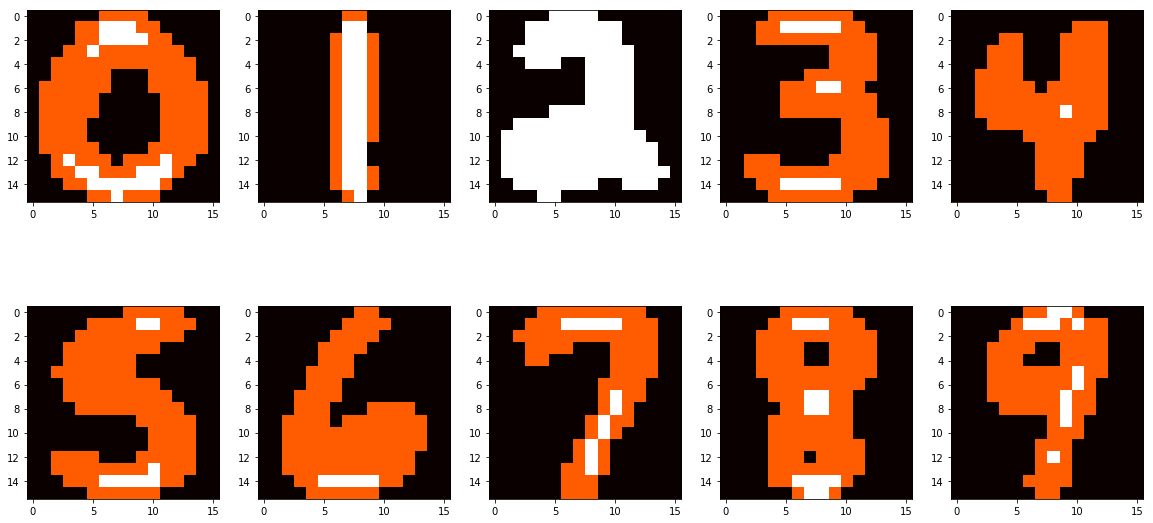

In [8]:
plt.figure(1, figsize=(20, 10))

for i in range(0,10):
    image = getNumberImage(cleaned_data,i,'mean')
    image = (image + 1).round()
    
    # Call signature: subplot(nrows, ncols, index, **kwargs)
    plt.subplot(2,5, 1 + i)
    plt.imshow(image, cmap='hot', interpolation='none')

plt.show()

---

## Verschiedene Ansätze mit K-Means zu Clustern

Wir nehmen an, dass jeder Bildpunkt ein Wert in dem 256 dimensionalen Raum der reelen Zahlen ist. In diesem Raum haben wir wie im 1-, 2-, oder 3-Dimensionalen auch das euklidische Abstandsmaß.

In [9]:
input_data = cleaned_data.iloc[:,1:].values
input_data.shape

(7291, 256)

In [10]:
# Set targets
exp = Experiment(cleaned_data[0].values)

### Add imputs

In [11]:
# input featurs are the individual pixels of the image - without transformation
exp.add_input_data('256_pixel', input_data)

In [12]:
# input featurs are the individual pixels of the image - quantized
exp.add_input_data('256_pixel_quant', (input_data * 2).round() / 2)

In [13]:
# input featurs are the individual pixels of the image - quantized
exp.add_input_data('256_pixel_quant2', input_data.round())

In [14]:
exp.add_config(KMeans(n_clusters=10), 'KMeans_10', '256_pixel')
exp.add_config(KMeans(n_clusters=10), 'KMeans_10_Q', '256_pixel_quant')
exp.add_config(KMeans(n_clusters=10), 'KMeans_10_Q2', '256_pixel_quant2')
exp.add_config(KMeans(n_clusters=10, n_init=20), 'KMeans__10__n_init20', '256_pixel')
#exp.add_config(GaussianMixture(n_components=10, covariance_type='full'), 'GMM__10__cov_full', '256_pixel')

In [15]:
exp.get_names()

['KMeans_10', 'KMeans_10_Q', 'KMeans_10_Q2', 'KMeans__10__n_init20']

In [16]:
exp.get_config_map()

CONFIG: KMeans_10 256_pixel 	Num features: 256
CONFIG: KMeans_10_Q 256_pixel_quant 	Num features: 256
CONFIG: KMeans_10_Q2 256_pixel_quant2 	Num features: 256
CONFIG: KMeans__10__n_init20 256_pixel 	Num features: 256


In [17]:
exp.fit()

Fitting  KMeans_10 ...  done in  2.20895814896 s.
Fitting  KMeans_10_Q ...  done in  2.0772819519 s.
Fitting  KMeans_10_Q2 ...  done in  2.18669295311 s.
Fitting  KMeans__10__n_init20 ...  done in  4.36007905006 s.


In [18]:
exp.predict_all(input_data)

Predicting data with KMeans_10 ...  done in  0.0263118743896 s.
Predicting data with KMeans_10_Q ...  done in  0.0264801979065 s.
Predicting data with KMeans_10_Q2 ...  done in  0.0221168994904 s.
Predicting data with KMeans__10__n_init20 ...  done in  0.0213918685913 s.


In [19]:
exp.get_count_df('KMeans_10')

,C_0,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9
0,524.0,7.0,0.0,0.0,512.0,119.0,15.0,10.0,0.0,7.0
1,0.0,0.0,1001.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0
2,3.0,563.0,3.0,9.0,12.0,6.0,34.0,40.0,12.0,49.0
3,2.0,13.0,1.0,12.0,1.0,2.0,545.0,8.0,2.0,72.0
4,0.0,14.0,42.0,139.0,1.0,6.0,0.0,440.0,5.0,5.0
5,14.0,10.0,0.0,5.0,7.0,111.0,297.0,40.0,3.0,69.0
6,40.0,37.0,9.0,2.0,31.0,532.0,1.0,10.0,0.0,2.0
7,0.0,2.0,3.0,168.0,0.0,0.0,0.0,23.0,445.0,4.0
8,2.0,10.0,11.0,41.0,4.0,3.0,30.0,10.0,1.0,430.0
9,0.0,0.0,5.0,445.0,0.0,0.0,2.0,125.0,61.0,6.0


In [20]:
exp.get_count_df('KMeans_10_Q')

,C_0,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9
0,7.0,10.0,525.0,15.0,0.0,0.0,7.0,0.0,118.0,512.0
1,0.0,0.0,0.0,0.0,1001.0,1.0,3.0,0.0,0.0,0.0
2,567.0,38.0,3.0,34.0,4.0,9.0,46.0,12.0,7.0,11.0
3,14.0,8.0,2.0,546.0,1.0,11.0,71.0,2.0,2.0,1.0
4,16.0,439.0,0.0,0.0,42.0,138.0,5.0,5.0,6.0,1.0
5,9.0,40.0,16.0,294.0,0.0,5.0,70.0,3.0,112.0,7.0
6,35.0,10.0,45.0,1.0,9.0,2.0,2.0,0.0,532.0,28.0
7,2.0,24.0,0.0,0.0,3.0,168.0,4.0,444.0,0.0,0.0
8,12.0,10.0,2.0,31.0,11.0,36.0,432.0,1.0,3.0,4.0
9,0.0,127.0,0.0,2.0,6.0,441.0,7.0,61.0,0.0,0.0


In [21]:
exp.get_count_df('KMeans_10_Q2')

,C_0,C_1,C_2,C_3,C_4,C_5,C_6,C_7,C_8,C_9
0,510.0,0.0,0.0,0.0,115.0,530.0,16.0,5.0,11.0,7.0
1,0.0,1000.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0
2,10.0,3.0,8.0,13.0,6.0,3.0,35.0,560.0,47.0,46.0
3,1.0,1.0,10.0,2.0,2.0,2.0,544.0,15.0,8.0,73.0
4,1.0,40.0,130.0,5.0,6.0,0.0,0.0,13.0,452.0,5.0
5,6.0,0.0,5.0,3.0,107.0,14.0,300.0,10.0,42.0,69.0
6,27.0,9.0,0.0,0.0,531.0,45.0,1.0,34.0,15.0,2.0
7,0.0,3.0,172.0,441.0,0.0,0.0,0.0,2.0,23.0,4.0
8,4.0,10.0,32.0,1.0,4.0,2.0,34.0,11.0,13.0,431.0
9,0.0,6.0,440.0,61.0,0.0,0.0,2.0,0.0,128.0,7.0


---

### TODO: Funktion zur Berechnung der besten Zuordnung

In [22]:
normalized_counts = exp.get_count_df('KMeans_10')
cluster_assignmend = normalized_counts.values.argmax(axis=1)
norm_np = normalized_counts.values
new_order = normalized_counts.values.argmax(axis=1)
unique_cluster_ids, unique_idx, inverse_map, cluster_counts = np.unique(new_order, return_counts=True, return_inverse=True, return_index=True)

# determine unassigned cluster ids
unprecise_clusters = []
idx = 0
for i in range(0,10):
    if unique_cluster_ids[idx] != i:
        unprecise_clusters.append(i)   
    else:
        idx += 1

# determine unclean clusters
for i in range(0, len(unique_cluster_ids)):
    # skip if no dublicate exists
    if cluster_counts[i] == 1:
        continue
    
    # dublicate
    confused_digits = []
    unprecise_clusters.append(new_order[unique_idx[i]])
    for j in range(unique_idx[i], 10):
        if new_order[j] == unique_cluster_ids[i]:
            confused_digits.append(j)
            
print "cluster", unprecise_clusters
print "digits", confused_digits

# 
idx = 0
for digit in confused_digits:
    new_order[digit] = unprecise_clusters[idx]
    idx += 1
        
print new_order
print normalized_counts.columns[new_order]
weights = []
for i in range(0, len(confused_digits)):
    for j in range(0, len(confused_digits)):
        if i == j:
            continue
        perm = new_order
        digit1 = new_order[confused_digits[i]]
        digit2 = new_order[confused_digits[j]]
        perm[confused_digits[i]] = digit2
        perm[confused_digits[j]] = digit1
        
        weight = normalized_counts.reindex(normalized_counts.columns[perm], axis=1).values.diagonal().sum()
        weights.append({"order": perm, "weight": weight})
    
print weights


cluster [4, 6]
digits [3, 5]
[0 2 1 4 7 6 5 8 9 3]
Index([u'C_0', u'C_2', u'C_1', u'C_4', u'C_7', u'C_6', u'C_5', u'C_8', u'C_9',
       u'C_3'],
      dtype='object')
[{'order': array([0, 2, 1, 4, 7, 6, 5, 8, 9, 3]), 'weight': 4932.0}, {'order': array([0, 2, 1, 4, 7, 6, 5, 8, 9, 3]), 'weight': 4678.0}]


-----